In [21]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from tensorflow import keras
# import torch
# import keras_cv
import skimage.io as skio
import glob
from skimage import transform
from xml.etree import ElementTree
from os import path
import re
import json
from tensorflow.keras import utils
from collections import OrderedDict
import tensorflow as tf
from tensorflow.data import Dataset
import glob
from skimage import io as skio
import numpy as np
from keras.layers import Resizing, Dense, Conv2D, Input, Flatten, Rescaling, MaxPooling2D, Conv2DTranspose
from keras.layers import UpSampling2D, GlobalAveragePooling2D, Conv1D, Reshape, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import LocallyConnected2D
from skimage import filters
from skimage import transform
from keras.optimizers import Adam, RMSprop, SGD
from keras.losses import MeanSquaredError, MeanAbsoluteError, MeanSquaredLogarithmicError
import typing
import random
from keras.models import Sequential
keras.backend.set_image_data_format("channels_last")

In [4]:
ANNOTE_TRAIN = "trainingdata1/annotations.xml"
IMAGES_TRAIN = "trainingdata1/images/training/"
ANNOTE_TEST = "TestData/annotations.xml"
IMAGES_TEST = "TestData/images/test/"
ANNOTE_MORE = "additionalTrainingLarger/annotations.xml"
IMAGES_MORE = "additionalTrainingLarger/images/frameset/"

In [5]:
def load_imageset(folder: str, newsize=(600,50)) -> np.ndarray | list:
    pngs = "*.png"
    tifs = "*.tif"
    if folder.endswith("/"):
        names1 = glob.glob(folder + pngs)
        names2 = glob.glob(folder + tifs)
    else:
        names1 = glob.glob(folder + "/" + pngs)
        names2 = glob.glob(folder + "/" + tifs)
    names = names1
    names.extend(names2)
    names.sort()
    raw_imgs = [skio.imread(name) for name in names]
    if newsize is not None:
        images = [transform.resize(image / 255.0, newsize)[...,np.newaxis] for image in raw_imgs]
    else:
        images = [(image / 255.0)[...,np.newaxis] for image in raw_imgs]
        return images
    return np.array(images)

In [6]:
def get_image_geometries(foldername: str):
    images = load_imageset(foldername, None)
    shapes = [image.shape for image in images]
    return shapes

def load_annotations(filename: str) -> ElementTree:
    with open(filename) as handle:
        text = handle.read()
    return ElementTree.fromstring(text)

def get_meniscus_centers(annotations: ElementTree) -> np.ndarray:
    images = annotations.findall("image")
    images.sort(key=lambda img : img.attrib['name'])
    points = [image.findall("points") for image in images]
    p = []
    for point_list in points:
        p.extend(point_list)
    centers = [point for point in p if point.attrib['label'] == 'MeniscusCenter']
    c_strs = [point.attrib['points'] for point in centers]
    cs_pairs = [s.split(',') for s in c_strs]
    center_coords = [(float(pair[0]), float(pair[1])) for pair in cs_pairs]
    return np.array(center_coords)

def structure_meniscuscenter_data(imagedata: np.ndarray, meniscus_centers: np.ndarray) -> Dataset:
    return Dataset.from_tensor_slices((imagedata, meniscus_centers))

In [7]:
train_img = load_imageset(IMAGES_TRAIN)
train_annote = load_annotations(ANNOTE_TRAIN)
train_geoms = get_image_geometries(IMAGES_TRAIN)
train_centers = get_meniscus_centers(train_annote)
train_mendata = structure_meniscuscenter_data(train_img, train_centers)
test_geoms = get_image_geometries(IMAGES_TEST)
test_img = load_imageset(IMAGES_TEST)
test_annote = load_annotations(ANNOTE_TEST)
test_centers = get_meniscus_centers(test_annote)
test_mendata = structure_meniscuscenter_data(test_img,test_centers)
add_img = load_imageset(IMAGES_MORE)
add_annote = load_annotations(ANNOTE_MORE)
add_centers = get_meniscus_centers(add_annote)
add_mendata = structure_meniscuscenter_data(add_img, add_centers)
mydata = train_mendata.concatenate(test_mendata).concatenate(add_mendata)

2023-02-11 15:58:38.421149: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-11 15:58:38.421167: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-11 15:58:38.421184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Silicon-Eye): /proc/driver/nvidia/version does not exist
2023-02-11 15:58:38.421428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
print(train_img.shape)
print(add_img.shape)

(91, 600, 50, 1)
(134, 600, 50, 1)


In [9]:
mytrainin = np.concatenate((train_img, add_img), axis=0)
mytrainout = np.concatenate((train_centers, add_centers), axis=0)

In [30]:
inputs = Input([600,50,1])
HEIGHT = 2
channels = 64
x = Resizing(600, 100)(inputs)
#x = Conv2D(filters=1, kernel_size=(1,1))(inputs)
for i in range(HEIGHT):
    x = Conv2D(filters=channels, kernel_size=(3,3))(x)
    x = Conv2D(filters=channels, kernel_size=(3,3))(x)
    x = MaxPooling2D()(x)
    channels *= 2
for i in range(HEIGHT):
    x = Conv2D(filters=channels, kernel_size=(3,3))(x)
    x = Conv2D(filters=channels, kernel_size=(3,3))(x)
    x = UpSampling2D()(x)
    channels //= 2

collapse = Conv2D(filters=2, kernel_size=(1,1))(x)
#flat = Flatten()(collapse)

out1 = Dense(2, activation="relu")(collapse)
out2 = GlobalAveragePooling2D()(out1)

model = keras.Model(inputs=inputs, outputs=out2)
model.compile(optimizer=Adam(), loss=MeanSquaredError())
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 600, 50, 1)]      0         
                                                                 
 resizing_11 (Resizing)      (None, 600, 100, 1)       0         
                                                                 
 conv2d_109 (Conv2D)         (None, 598, 98, 64)       640       
                                                                 
 conv2d_110 (Conv2D)         (None, 596, 96, 64)       36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 298, 48, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_111 (Conv2D)         (None, 296, 46, 128)      73856     
                                                           

In [29]:
model.fit(mydata.batch(50))

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

268.56
[ 31.675207 276.14087 ]


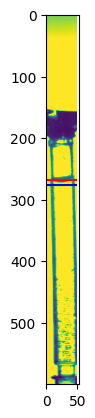

In [55]:
x,y = outputs.numpy()
print(y)

print(pair)
outs = m.numpy()
pyplot.imshow(inputs)
pyplot.hlines(y, 0, 50, color="red")
pyplot.hlines(pair[1], 0, 50, color="blue")

array([ 31.675207, 276.14087 ], dtype=float32)

In [79]:
r = outs.reshape((600*144*6,2))

(array([   468.,   2984.,  30552.,  14352.,  19264.,  26364.,  22136.,
         30412., 251172., 120696.]),
 array([177.50824, 191.60754, 205.70683, 219.80614, 233.90543, 248.00473,
        262.10403, 276.20334, 290.3026 , 304.40192, 318.50122],
       dtype=float32),
 <BarContainer object of 10 artists>)

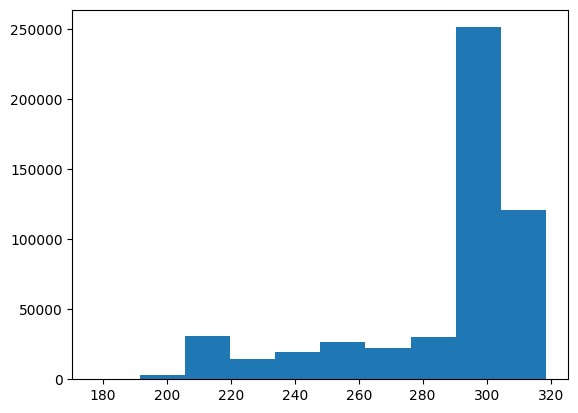

In [80]:
pyplot.hist(r[:,1])

In [72]:
m.shape

TensorShape([600, 144, 6, 2])

In [73]:
inputs

<tf.Tensor: shape=(600, 50, 1), dtype=float64, numpy=
array([[[0.81509804],
        [0.80568627],
        [0.81568627],
        ...,
        [0.81176471],
        [0.81294118],
        [0.81921569]],

       [[0.81882353],
        [0.80627451],
        [0.80980392],
        ...,
        [0.82254902],
        [0.82078431],
        [0.82705882]],

       [[0.80843137],
        [0.81784314],
        [0.81666667],
        ...,
        [0.82156863],
        [0.81745098],
        [0.82686275]],

       ...,

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.24607843],
        [0.16901961],
        [0.15019608]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.25098039],
        [0.17627451],
        [0.15431373]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.24705882],
        [0.17352941],
        [0.15784314]]])>